# Demo
Integrating sub-cellular spots into single-cellular spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('synthesize/ref_snRNA_mouse_kidney_h5ad_Stacked/GSE265819.annotated.final.h5ad'),
    sp_adata=sc.read_h5ad('synthesize/synthetic_data/groundtruth/spatial_0.h5ad'),
    sn_colname_celltype='annotation',
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 30308 × 42563
    obs: 'batch', 'n_counts', 'mt_proportion', 'old_index', 'cell_type'
    uns: 'annotation_colors', 'batch_colors', 'log1p', 'neighbors', 'pca', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'
- sp_adata: AnnData object with n_obs × n_vars = 9216 × 42563
    obs: 'x', 'y', 'cell_type_groundtruth', 'cell_belong_groundtruth', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [3]:
# On subsample for speed up
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.pp.subsample(data_preper.sn_adata, fraction=1/4, copy=True),
    sp_adata=
    sc.read_h5ad('synthesize/synthetic_data/groundtruth/spatial_0.h5ad'),
    sn_colname_celltype='cell_type',
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 7577 × 42563
    obs: 'batch', 'n_counts', 'mt_proportion', 'old_index', 'cell_type', 'old_index_copy'
    uns: 'annotation_colors', 'batch_colors', 'log1p', 'neighbors', 'pca', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'
- sp_adata: AnnData object with n_obs × n_vars = 9216 × 42563
    obs: 'x', 'y', 'cell_type_groundtruth', 'cell_belong_groundtruth', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [4]:
# Step 2. Train a local classifier
clf = pytacs.SVM(0.75, log1p=True, normalize=True, on_PCs=False)
clf.fit(
    sn_adata=data_preper.sn_adata
)

In [5]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandlerParallel(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=50,
                            threshold_adjacent=1.2,
                            threshold_delta_n_features=100000,  # suspended
                            n_parallel=1000,
                            )
print(sph)

--- Spatial Handler Autopilot Parallel (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 9216 × 42563
    obs: 'x', 'y', 'cell_type_groundtruth', 'cell_belong_groundtruth', 'old_index'
- threshold_adjacent: 1.2
- local_classifier: <pytacs.classifier.SVM object at 0x7f6181298fb0>
    + threshold_confidence: 0.75
    + has_negative_control: False
- max_spots_per_cell: 50
- scale_rbf: 1.0
- pre-mapped: False
- n_parallel: 1000
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [6]:
sph.run_preMapping()

Running first round premapping ...
Running second round premapping ...


100%|██████████| 9216/9216 [00:03<00:00, 2974.48it/s]

Done.


In [7]:
sph.run_segmentation(
    n_spots_add_per_step=3,
    coverage_to_stop=0.99,
    max_iter=10,
    verbose=False,
    warnings=False,
    print_summary=True,
)

 40%|████      | 4/10 [22:12<33:18, 333.11s/it]

--- Summary ---
Queried 4148 spots, of which 4148 made up confident single cells.
Classes total: {5: 1167, 0: 1104, 4: 48, 1: 399, 6: 946, 2: 397, 7: 12, 3: 75}
Coverage: 100.00%
--- --- --- --- ---



In [8]:
import dill
dill.dump_session('session.Test_on_synthetic_data.version1.1.3_autopilot.dill')

In [9]:
# import dill
# dill.load_session('session.Test_on_synthetic_data.version1.1.3_autopilot.dill')

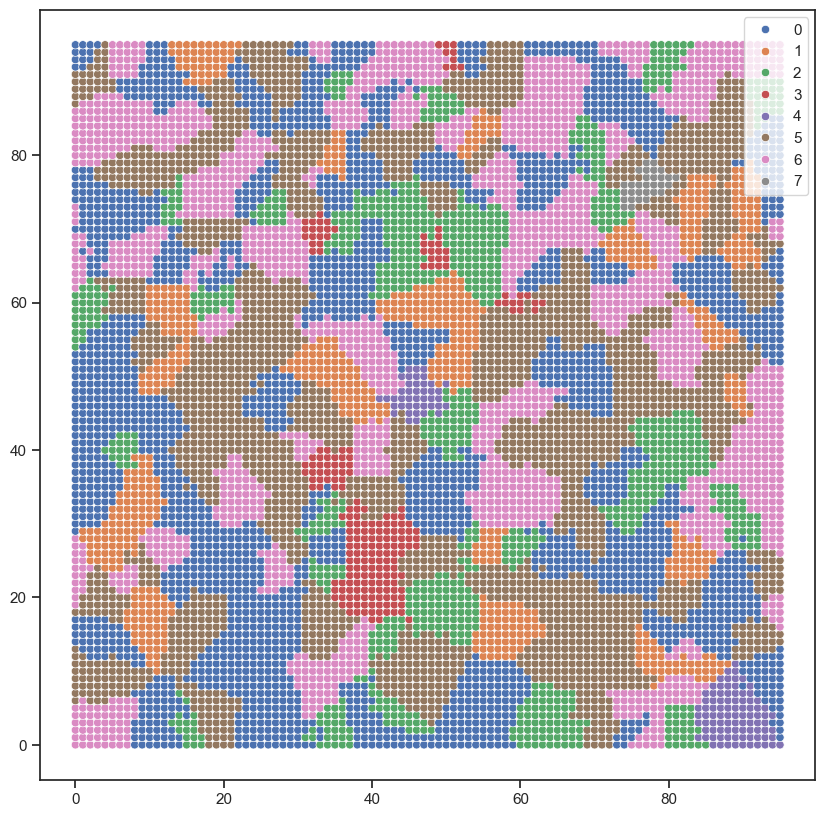

In [10]:
# See the integrated spots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.set_theme(style='ticks')
sph.run_plotClasses()
plt.show()

In [11]:
# Step 4. Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData(cache=True, force=True)
print(sp_singleCell)

AnnData object with n_obs × n_vars = 4148 × 42563
    obs: 'x', 'y', 'cell_type_groundtruth', 'cell_belong_groundtruth', 'old_index', 'cell_type_premapping2', 'confidence', 'cell_type'


In [12]:
clf.classes

array(['CCD', 'DCT', 'ENDO', 'IMMUNE', 'PODS', 'PT', 'TAL', 'UROTHELIUM'],
      dtype='<U10')

In [13]:
def get_type_name_by_id(index: int) -> str:
    if index == -1:
        return 'Undefined'
    return clf.classes[index]

In [14]:
sp_singleCell.obs['cell_type_name'] = list(
    map(get_type_name_by_id, sp_singleCell.obs['cell_type'])
)

In [15]:
sp_singleCell.obs

,x,y,cell_type_groundtruth,cell_belong_groundtruth,old_index,cell_type_premapping2,confidence,cell_type,cell_type_name
0,0,0,TAL,209,0,6,0.945070,5,PT
1,0,1,TAL,209,1,6,0.950194,2,ENDO
3,0,3,TAL,209,3,6,0.787202,6,TAL
4,0,4,TAL,209,4,6,0.756562,6,TAL
5,0,5,TAL,209,5,6,0.957148,6,TAL
...,...,...,...,...,...,...,...,...,...
9203,95,83,CCD,27,9203,0,0.903788,5,PT
9205,95,85,CCD,27,9205,0,0.931026,6,TAL
9212,95,92,TAL,12,9212,6,0.933561,3,IMMUNE
9214,95,94,TAL,12,9214,6,0.819588,2,ENDO


In [16]:
(sp_singleCell.obs['cell_type_name'] == sp_singleCell.obs['cell_type_groundtruth']).mean()

0.2143201542912247

In [17]:
import numpy as np
spot_types_pred = np.array(list(map(get_type_name_by_id, sph.get_spatial_classes())))
spot_types_truth = data_preper.sp_adata.obs['cell_type_groundtruth'].values

In [18]:
(spot_types_pred == spot_types_truth).mean()

0.9423828125

<Axes: xlabel='x', ylabel='y'>

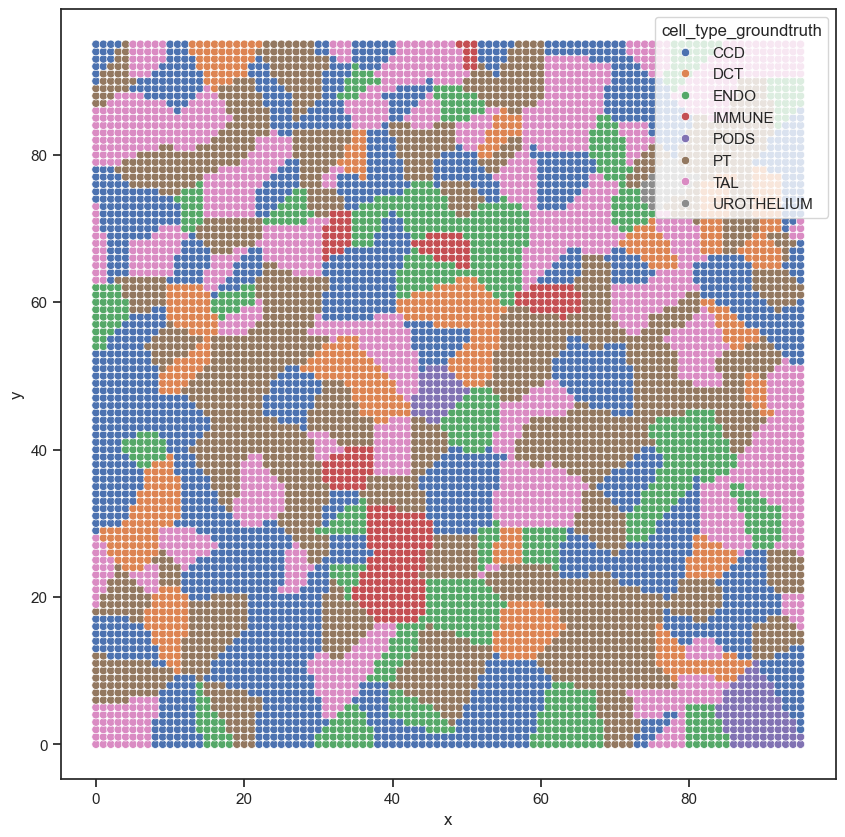

In [19]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=data_preper.sp_adata.obs['x'],
    y=data_preper.sp_adata.obs['y'],
    hue=data_preper.sp_adata.obs['cell_type_groundtruth'],
    hue_order=clf.classes
)